###  Modèle CNN type LeNet avec détourage

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../files_detour.csv',index_col=0)

In [3]:
src_img = '../images_detour/'

In [4]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [5]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour/BA_102750.jpg,BA_102750.jpg,basophil,0


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [9]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224])
    img = tf.cast(img, tf.float32)/255.
    return img

In [10]:
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [12]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [13]:
# Création d'un modèle type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=10,activation='softmax')) #10 Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model_CNN()

In [15]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 1236s 2s/step - loss: 1.0185 - accuracy: 0.6397 - val_loss: 0.6874 - val_accuracy: 0.7610
Epoch 2/16
800/800 [==============================] - 1222s 2s/step - loss: 0.5936 - accuracy: 0.7942 - val_loss: 0.5357 - val_accuracy: 0.8148
Epoch 3/16
800/800 [==============================] - 1235s 2s/step - loss: 0.4724 - accuracy: 0.8398 - val_loss: 0.5294 - val_accuracy: 0.8105
Epoch 4/16
800/800 [==============================] - 1238s 2s/step - loss: 0.3879 - accuracy: 0.8683 - val_loss: 0.4709 - val_accuracy: 0.8408
Epoch 5/16
800/800 [==============================] - 1190s 1s/step - loss: 0.3180 - accuracy: 0.8937 - val_loss: 0.4909 - val_accuracy: 0.8404
Epoch 6/16
800/800 [==============================] - 1244s 2s/step - loss: 0.2619 - accuracy: 0.9135 - val_loss: 0.5137 - val_accuracy: 0.8330
Epoch 7/16
800/800 [==============================] - 1198s 1s/step - loss: 0.2096 - accuracy: 0.9302 - val_loss: 0.4710 - val_accuracy:

In [14]:
model.save_weights("cnn_10_detour_weights")

#### Prédiction sur les données d'évaluation

In [15]:
model = model_mobileNet()
model.load_weights("cnn_10_detour_weights")

In [16]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [17]:
model.evaluate(dataset_eval)

99/99 [==============================] - 44s 441ms/step - loss: 0.4823 - accuracy: 0.8383


[0.4822677969932556, 0.8383423089981079]

 * Score inférieur avec détourage

In [18]:
#Classes prédites
predict = model.predict(dataset_eval)

In [19]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.91      0.80      0.85       119
       blast       0.83      0.86      0.84       327
  eosinophil       0.93      0.93      0.93       323
erythroblast       0.88      0.89      0.89       210
          ig       0.73      0.64      0.68       381
  lymphocyte       0.92      0.81      0.86       453
    monocyte       0.62      0.81      0.70       274
  neutrophil       0.91      0.92      0.91       573
    platelet       0.99      0.98      0.99       242
      smudge       0.68      0.75      0.71       259

    accuracy                           0.84      3161
   macro avg       0.84      0.84      0.84      3161
weighted avg       0.85      0.84      0.84      3161



In [20]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,95,1,4,1,13,1,3,0,0,1
blast,0,280,0,0,11,0,25,0,0,11
eosinophil,0,0,301,1,1,0,3,8,0,9
erythroblast,0,0,0,187,10,4,2,7,0,0
ig,8,28,4,0,243,4,45,23,0,26
lymphocyte,0,4,0,17,12,366,33,1,1,19
monocyte,1,11,0,0,15,3,222,5,0,17
neutrophil,0,0,6,0,22,4,8,526,1,6
platelet,0,0,0,5,0,0,0,0,237,0


In [21]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [22]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

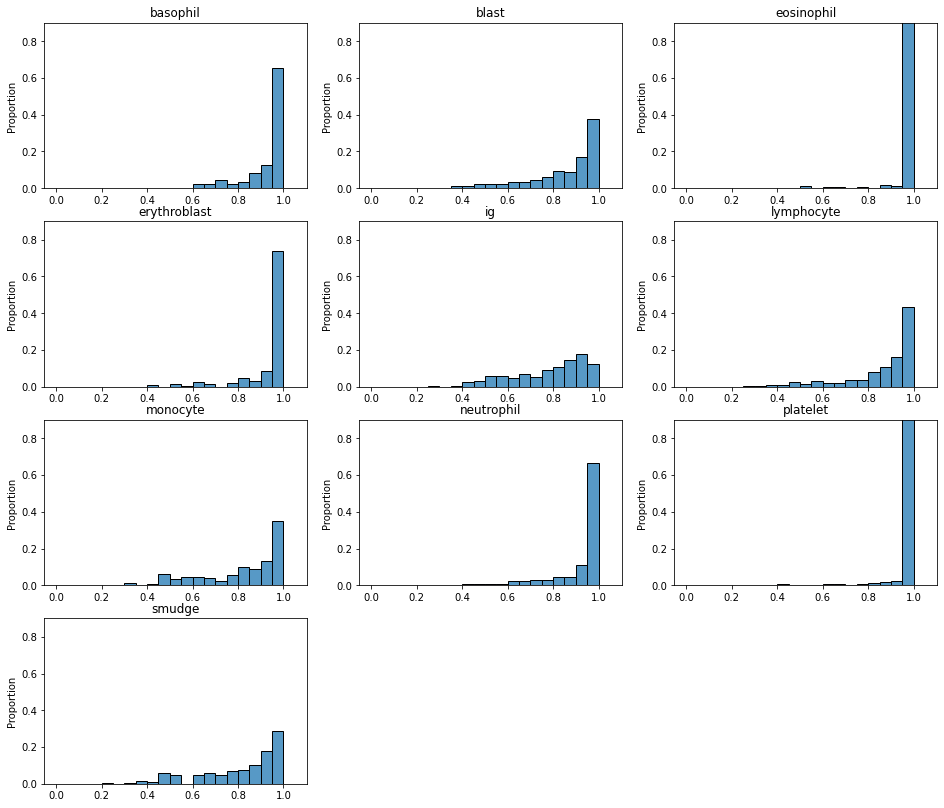

In [23]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [24]:
import gradcam_dataset

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [29]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

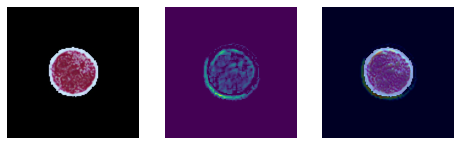

In [30]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

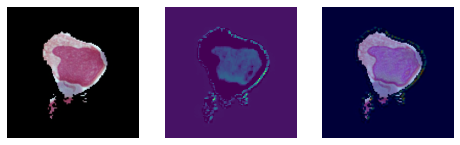

In [31]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

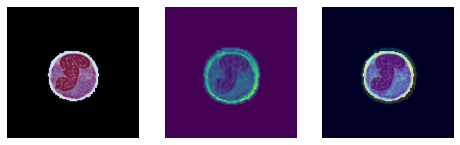

In [32]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

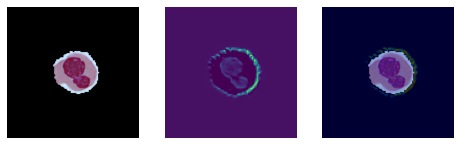

In [33]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

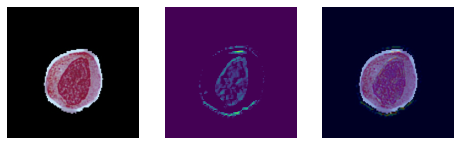

In [41]:
path = data[data['filename']=='MY_582963.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

Cellule non prédite dans la catégorie attendue


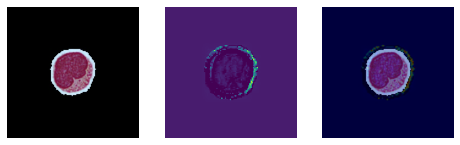

In [35]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

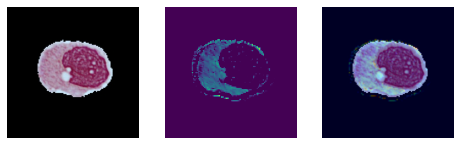

In [36]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

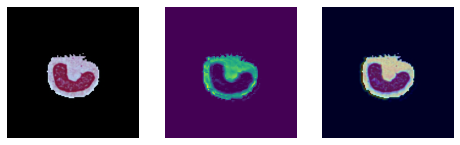

In [37]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

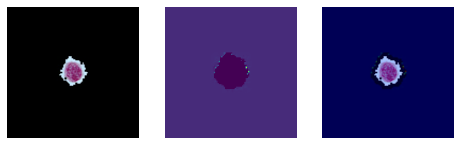

In [44]:
path = data[data['filename']=='PLATELET_19307.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

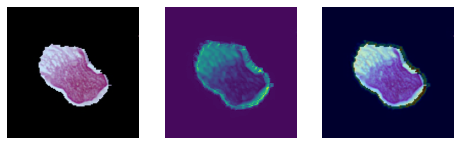

In [39]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)